### Purpose of the Notebook

The purpose of this notebook is to conduct statistical inference of the parameters in the JMAK and GL models _vs._ non-linear least squares estimation. Inference provides useful information regarding the distribution of the model parameters given the data, which is crucial for assessing confidence in the parameter fit.

As with the least-squares procedure, the non-linear structure of the model means that obtaining analytical distributions of the model parameters is difficult, and perhaps even impossible. This is a common complication, and the posterior distribution of the parameters may be obtained using standar numerical methods, specifically using Markov Chain Monte Carlo (MCMC) methods, and in particular the No U-Turn Samplers (NUTS). 

As with many numerical techinques, the "initial values" _i.e._ the initial "guesses" of the parameters are crucial to satisfactory results, and we'll use the least squares fitted values to inform the inference. 

### Statistical Inference Model
As before, we consider each data set independently. Let $\hat{\mathbf{X}} = f(\mathbf{t},\mathbf{T}; \theta) $ be the model predicted values at a vector of times and temperatures with parameter vector $\theta$ using either the JMAK or GL model. We suppose that

$
\mathbf{X} \sim \mathcal{N}(\mathbf{\hat{X}},\sigma^2 \Sigma) 
$ 

Where $\Sigma$ is a diagonal, constant matrix with known experimental error and $\sigma^2$ is some unknown multiplier, equivalent to Weighted Least Squares.

We want to obtain the distribution of the parameters $\theta$ after observing the data $\mathbf{X,t,T}$. Using Baye's rule:

$
p(\theta| \mathbf{X,t,T}) \propto \mathcal{L}(\mathbf{X,t,T} | \theta)p(\theta) \\ 
\mathcal{L}(\mathbf{X,t,T} | \theta) = \mathcal{N}(\mathbf{\hat{X} - X},\sigma^2 \Sigma)  \\
\hat{\mathbf{X}} = f(\mathbf{t},\mathbf{T}; \theta)
$

Focusing on the JMAK model, we have $\theta = [a_1,B_1,a_2,B_2,n]$. We can use our prior estimates of $\theta$ obtained from [arrhenius_process_estimation.ipynb](arrhenius_process_estimation.ipynb) to set the priors using $\theta_i \sim \mathcal{N}(\mu_i,\sigma^2_i)$. The same approach can obviously be extended to the GL model.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from matplotlib import rc

import pickle
rc('font',**{'family':'serif','serif':['Times New Roman'],'weight': 'bold'})
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = "".join([r"\usepackage{newtxtext,newtxmath}",r"\boldmath"])
import numpyro
from jax import random
import jax.numpy as jnp
from numpyro.distributions import Normal, LogNormal
from numpyro.infer import init_to_mean, init_to_value
from common_util import setup_axis_default,jmak_fit_model_setup,gl_fit_model_setup,get_model_params, resampled_adam
from typing import Callable
import dill
import jax

#map the data files to various items that are useful to make sure that 
#inferences are performed correctly

file_to_label  = {'rf_data/alfonso_data/highly_rolled.csv': 'Lopez et al. (2015) - HR',
                'rf_data/alfonso_data/moderate_roll.csv': 'Lopez et al. (2015) - MR',
                'rf_data/richou_data/batch_a_data.csv': 'Richou et al. (2020) - Batch A',
                'rf_data/richou_data/batch_b_data.csv': 'Richou et al. (2020) - Batch B',
                 'rf_data/yu_data/data.csv': 'Yu et al. (2017)'}

file_to_model =  {'rf_data/alfonso_data/highly_rolled.csv': 'alfonso_data_hr',
                'rf_data/alfonso_data/moderate_roll.csv': 'alfonso_data_mr',
                'rf_data/richou_data/batch_a_data.csv': 'richou_batch_a',
                'rf_data/richou_data/batch_b_data.csv': 'richou_batch_b',
                 'rf_data/yu_data/data.csv': 'yu'}

file_to_multiplier = {'rf_data/alfonso_data/highly_rolled.csv': 3600.,
                      'rf_data/alfonso_data/moderate_roll.csv': 3600.,
                        'rf_data/richou_data/batch_a_data.csv': 1.0,
                        'rf_data/richou_data/batch_b_data.csv': 1.0,
                        'rf_data/yu_data/data.csv': 3600}


c:\Users\mlanahan3\Anaconda3\envs\py312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### JMAK Model Inference
Below is a cell that samples the parameter posterior of the JMAK model for a specific data set. Some experimentation and examination of the $\hat{r}$ diagnostic for each inference confirms that the inference parameters (the number of warmup samples, number of samples, initial conditions, ect...) provide satisfactory results. The results of each inference are written to a file for later analysis.

In [2]:
rng_key = random.PRNGKey(155)
rng_key, rng_key_ = random.split(rng_key)

def jmak_numpyro_model(t: jnp.ndarray,
                      T: jnp.ndarray,
                      X: jnp.ndarray,
                      std: jnp.ndarray,
                      pmean: jnp.ndarray,
                      pstd: jnp.ndarray) -> None:
    """
    numpyro/jax numpy compatible model for the JMAK model
    """

    # priors
    a1 = numpyro.sample('a1',Normal(pmean[0],pstd[0]))
    a2 = numpyro.sample('a2',Normal(pmean[2],pstd[2]))
    B1 = numpyro.sample('B1',Normal(pmean[1],pstd[1]))
    B2 = numpyro.sample('B2',Normal(pmean[3],pstd[3]))
    n = numpyro.sample('n',LogNormal(pmean[4]/2))

    sigma = numpyro.sample('sigma',numpyro.distributions.Exponential(10.0))

    # arrhenius equations
    b = jnp.exp(a1 + B1/T)
    t_inc = jnp.exp(a2 + B2/T)

    #model prediction
    Xhat = 1.0 - jnp.exp(-b**n*(jnp.where(t > t_inc, t,t_inc) - t_inc)**n)
    
    # likelihood
    with numpyro.plate("data", t.shape[0]):
        numpyro.sample('obs',Normal(Xhat,scale = sigma + std),obs = X)

#specify the model name and the file containing the data we are fitting to
model_name = 'JMAK_{}'
file = 'rf_data/yu_data/data.csv'

#same function as in initial_least_squares_comparison.ipynb
t,T,X,df,bounds,p0 = jmak_fit_model_setup(file, mult = file_to_multiplier[file])

#estimate the standard deviation of the parameters
pstd= (bounds[:,1] - bounds[:,0])/4
pstd = pstd[1:]

#read in least squares estimates made in initial_least_squares_comparison.ipynb
with open(f'.model/{model_name.format(file_to_model[file])}_weighted.pkl','rb') as f:
    a1,B1,a2,B2,n = get_model_params(pickle.load(f))

#initialize the model with the least squares estimates
init_values = {'a1': a1, 'a2': a2, 'B1': B1, 'B2': B2, 'n': n, 'sigma': 1.}
p0 = np.array([a1,B1,a2,B2,n])

#setup the NUTS kernel 
nuts_kernel = numpyro.infer.NUTS(jmak_numpyro_model,init_strategy= init_to_mean)
mcmc = numpyro.infer.MCMC(
    nuts_kernel,
    num_samples=20000,
    num_warmup=50000,
    num_chains= 1,
)

#run the MCMC
mcmc.run(rng_key_,jnp.array(t),jnp.array(T),jnp.array(X),jnp.array(df['std'].to_numpy()),
         jnp.array(p0),jnp.array(pstd),init_params= init_values)

mcmc.print_summary()

posterior_samples = mcmc.get_samples()

with open(f'.inference/{model_name.format(file_to_label[file])}_samples.pkl','wb') as f:
    pickle.dump(posterior_samples,f)


No standard deviation column found, using 0.001 for all values


  0%|          | 0/70000 [00:01<?, ?it/s]


KeyboardInterrupt: 

### JMAK Maximum likelihood optimization

In [2]:
def jmak_posterior(params: jnp.ndarray,
                    t: jnp.ndarray,
                    T: jnp.ndarray,
                    X: jnp.ndarray,
                    std: jnp.ndarray) -> None:
    """
    numpyro/jax numpy compatible model for the JMAK model
    """

    # priors
    a1,B1,a2,B2,n,log_sigma = params
    
    # arrhenius equations
    b = jnp.exp(a1 + B1/T)
    t_inc = jnp.exp(a2 + B2/T)

    #model prediction
    Xhat = 1.0 - jnp.exp(-b**n*(jnp.where(t > t_inc, t,t_inc) - t_inc)**n)
    
    # likelihood
    likelihood = Normal(Xhat,scale = jnp.exp(log_sigma) + std)

    return likelihood.log_prob(X).sum() 

model_name = 'JMAK_{}'
file = 'rf_data/yu_data/data.csv'


#same function as in initial_least_squares_comparison.ipynb
t,T,X,df,bounds,p0 = jmak_fit_model_setup(file, mult = file_to_multiplier[file])
t,T,X,std = jnp.array(t),jnp.array(T),jnp.array(X),jnp.array(df['std'].to_numpy())

with open(f'.model/{model_name.format(file_to_model[file])}_weighted.pkl','rb') as f:
    a1,B1,a2,B2,n = get_model_params(pickle.load(f))

p0 = jnp.array([a1,B1,a2,B2,n])

def opt_jmak(params: np.ndarray):
    return -jmak_posterior(params,t,T,X,std)

model_params = ['a1','B1','a2','B2','n','sigma']
with open(f'.inference/{model_name.format(file_to_label[file])}_samples.pkl','rb') as f:
    posterior_samples = pd.DataFrame.from_dict(pickle.load(f))[model_params]

posterior_samples['sigma'] = np.log(posterior_samples['sigma'])
NUM_SAMPLES = 50
posterior_likelihood = jax.vmap(opt_jmak,in_axes = (0))(posterior_samples[model_params].to_numpy())
init_samples = posterior_samples.iloc[np.argsort(posterior_likelihood)[:NUM_SAMPLES]][model_params].to_numpy()
init_samples = np.concatenate([posterior_samples.mean(axis = 0).to_numpy()[np.newaxis,:],init_samples],axis = 0)
opt_params,posterior_value = resampled_adam(init_samples,opt_jmak,lr = 1e-3,opt_iter = int(2e3))
opt_params = np.array(opt_params)
opt_params[-1] = np.exp(opt_params[-1])

inf_summary = pd.DataFrame({'mean': posterior_samples.mean(axis = 0),
                       'std': posterior_samples.std(axis = 0),
                       'ml': opt_params},
                      index = list(posterior_samples.keys()))

inf_summary.to_csv(f'.inference/{model_name.format(file_to_label[file])}_params.csv')



No standard deviation column found, using 0.001 for all values


Optimizing:   0%|          | 0/51 [00:00<?, ?it/s]

[ 5.6283321e+00 -2.3166617e+04 -4.8902294e+01 -9.2841475e+03
  1.3363210e+00 -2.3802383e+00]


Optimizing:   2%|▏         | 1/51 [00:00<00:28,  1.78it/s]

[ 5.1120763e+00 -2.2230094e+04 -2.3737190e+01  4.7243973e+04
  1.2533084e+00 -2.4520385e+00]


Optimizing:   4%|▍         | 2/51 [00:00<00:20,  2.39it/s]

[ 5.1120763e+00 -2.2230094e+04 -2.3737190e+01  4.7243973e+04
  1.2533084e+00 -2.4520385e+00]


Optimizing:   6%|▌         | 3/51 [00:01<00:18,  2.57it/s]

[ 5.1120763e+00 -2.2230094e+04 -2.3737190e+01  4.7243973e+04
  1.2533084e+00 -2.4520385e+00]


Optimizing:   8%|▊         | 4/51 [00:01<00:18,  2.59it/s]

[ 5.1120763e+00 -2.2230094e+04 -2.3737190e+01  4.7243973e+04
  1.2533084e+00 -2.4520385e+00]


Optimizing:  10%|▉         | 5/51 [00:01<00:16,  2.74it/s]

[ 5.1120763e+00 -2.2230094e+04 -2.3737190e+01  4.7243973e+04
  1.2533084e+00 -2.4520385e+00]


Optimizing:  12%|█▏        | 6/51 [00:02<00:15,  2.84it/s]

[ 5.1120763e+00 -2.2230094e+04 -2.3737190e+01  4.7243973e+04
  1.2533084e+00 -2.4520385e+00]


Optimizing:  14%|█▎        | 7/51 [00:02<00:15,  2.91it/s]

[ 5.1120763e+00 -2.2230094e+04 -2.3737190e+01  4.7243973e+04
  1.2533084e+00 -2.4520385e+00]


Optimizing:  16%|█▌        | 8/51 [00:02<00:14,  2.93it/s]

[ 5.1120763e+00 -2.2230094e+04 -2.3737190e+01  4.7243973e+04
  1.2533084e+00 -2.4520385e+00]


Optimizing:  18%|█▊        | 9/51 [00:03<00:14,  2.92it/s]

[ 5.1120763e+00 -2.2230094e+04 -2.3737190e+01  4.7243973e+04
  1.2533084e+00 -2.4520385e+00]


Optimizing:  20%|█▉        | 10/51 [00:03<00:14,  2.87it/s]

[ 5.1120763e+00 -2.2230094e+04 -2.3737190e+01  4.7243973e+04
  1.2533084e+00 -2.4520385e+00]


Optimizing:  22%|██▏       | 11/51 [00:04<00:14,  2.72it/s]

[ 5.1120763e+00 -2.2230094e+04 -2.3737190e+01  4.7243973e+04
  1.2533084e+00 -2.4520385e+00]


Optimizing:  24%|██▎       | 12/51 [00:04<00:13,  2.85it/s]

[ 4.5107422e+00 -2.1350770e+04 -3.7883808e+01  6.7884414e+04
  1.3222069e+00 -2.4852600e+00]


Optimizing:  25%|██▌       | 13/51 [00:04<00:13,  2.85it/s]

[ 4.5107422e+00 -2.1350770e+04 -3.7883808e+01  6.7884414e+04
  1.3222069e+00 -2.4852600e+00]


Optimizing:  27%|██▋       | 14/51 [00:05<00:13,  2.84it/s]

[ 4.5107422e+00 -2.1350770e+04 -3.7883808e+01  6.7884414e+04
  1.3222069e+00 -2.4852600e+00]


Optimizing:  29%|██▉       | 15/51 [00:05<00:12,  2.80it/s]

[ 4.5107422e+00 -2.1350770e+04 -3.7883808e+01  6.7884414e+04
  1.3222069e+00 -2.4852600e+00]


Optimizing:  31%|███▏      | 16/51 [00:05<00:12,  2.79it/s]

[ 4.5107422e+00 -2.1350770e+04 -3.7883808e+01  6.7884414e+04
  1.3222069e+00 -2.4852600e+00]


Optimizing:  33%|███▎      | 17/51 [00:06<00:11,  2.89it/s]

[ 4.4534855e+00 -2.1247826e+04 -3.8315182e+01  6.8472711e+04
  1.3329935e+00 -2.4754057e+00]


Optimizing:  35%|███▌      | 18/51 [00:06<00:11,  2.92it/s]

[ 4.4534855e+00 -2.1247826e+04 -3.8315182e+01  6.8472711e+04
  1.3329935e+00 -2.4754057e+00]


Optimizing:  37%|███▋      | 19/51 [00:06<00:10,  2.98it/s]

[ 4.4534855e+00 -2.1247826e+04 -3.8315182e+01  6.8472711e+04
  1.3329935e+00 -2.4754057e+00]


Optimizing:  39%|███▉      | 20/51 [00:07<00:10,  2.88it/s]

[ 4.4534855e+00 -2.1247826e+04 -3.8315182e+01  6.8472711e+04
  1.3329935e+00 -2.4754057e+00]


Optimizing:  41%|████      | 21/51 [00:07<00:10,  2.98it/s]

[ 4.4534855e+00 -2.1247826e+04 -3.8315182e+01  6.8472711e+04
  1.3329935e+00 -2.4754057e+00]


Optimizing:  43%|████▎     | 22/51 [00:07<00:09,  2.93it/s]

[ 4.4534855e+00 -2.1247826e+04 -3.8315182e+01  6.8472711e+04
  1.3329935e+00 -2.4754057e+00]


Optimizing:  45%|████▌     | 23/51 [00:08<00:11,  2.50it/s]

[ 4.4534855e+00 -2.1247826e+04 -3.8315182e+01  6.8472711e+04
  1.3329935e+00 -2.4754057e+00]


Optimizing:  47%|████▋     | 24/51 [00:08<00:10,  2.49it/s]

[ 5.3849311e+00 -2.2702508e+04 -1.4454905e+01  3.3553949e+04
  1.0999440e+00 -2.3046994e+00]


Optimizing:  49%|████▉     | 25/51 [00:09<00:10,  2.55it/s]

[ 5.3849311e+00 -2.2702508e+04 -1.4454905e+01  3.3553949e+04
  1.0999440e+00 -2.3046994e+00]


Optimizing:  51%|█████     | 26/51 [00:09<00:09,  2.51it/s]

[ 4.9394131e+00 -2.1990312e+04 -3.4765793e+01  6.3027297e+04
  1.3370553e+00 -2.5544291e+00]


Optimizing:  53%|█████▎    | 27/51 [00:09<00:09,  2.60it/s]

[ 4.5575318e+00 -2.1490326e+04 -3.7845642e+01  6.7134969e+04
  1.3265319e+00 -2.4848211e+00]


Optimizing:  55%|█████▍    | 28/51 [00:10<00:08,  2.64it/s]

[ 5.6238708e+00 -2.3107449e+04 -4.1282337e+01  7.3147094e+04
  1.1240634e+00 -2.5185597e+00]


Optimizing:  57%|█████▋    | 29/51 [00:10<00:08,  2.72it/s]

[ 5.6238708e+00 -2.3107449e+04 -4.1282337e+01  7.3147094e+04
  1.1240634e+00 -2.5185597e+00]


Optimizing:  59%|█████▉    | 30/51 [00:10<00:07,  2.82it/s]

[ 5.6238708e+00 -2.3107449e+04 -4.1282337e+01  7.3147094e+04
  1.1240634e+00 -2.5185597e+00]


Optimizing:  61%|██████    | 31/51 [00:11<00:06,  3.08it/s]

[ 5.6238708e+00 -2.3107449e+04 -4.1282337e+01  7.3147094e+04
  1.1240634e+00 -2.5185597e+00]


Optimizing:  63%|██████▎   | 32/51 [00:11<00:06,  2.94it/s]

[ 5.6238708e+00 -2.3107449e+04 -4.1282337e+01  7.3147094e+04
  1.1240634e+00 -2.5185597e+00]


Optimizing:  65%|██████▍   | 33/51 [00:11<00:06,  2.93it/s]

[ 5.6238708e+00 -2.3107449e+04 -4.1282337e+01  7.3147094e+04
  1.1240634e+00 -2.5185597e+00]


Optimizing:  67%|██████▋   | 34/51 [00:12<00:05,  2.92it/s]

[ 5.6238708e+00 -2.3107449e+04 -4.1282337e+01  7.3147094e+04
  1.1240634e+00 -2.5185597e+00]


Optimizing:  69%|██████▊   | 35/51 [00:12<00:05,  2.92it/s]

[ 5.6238708e+00 -2.3107449e+04 -4.1282337e+01  7.3147094e+04
  1.1240634e+00 -2.5185597e+00]


Optimizing:  71%|███████   | 36/51 [00:12<00:05,  2.90it/s]

[ 5.6238708e+00 -2.3107449e+04 -4.1282337e+01  7.3147094e+04
  1.1240634e+00 -2.5185597e+00]


Optimizing:  73%|███████▎  | 37/51 [00:13<00:04,  2.92it/s]

[ 5.6238708e+00 -2.3107449e+04 -4.1282337e+01  7.3147094e+04
  1.1240634e+00 -2.5185597e+00]


Optimizing:  75%|███████▍  | 38/51 [00:13<00:04,  2.88it/s]

[ 4.4943423e+00 -2.1383248e+04 -3.9087070e+01  6.8637352e+04
  1.3217727e+00 -2.4734125e+00]


Optimizing:  76%|███████▋  | 39/51 [00:13<00:04,  2.91it/s]

[ 3.6832454e+00 -2.0033244e+04 -4.5769119e+01  7.9316438e+04
  1.3428643e+00 -2.5171490e+00]


Optimizing:  78%|███████▊  | 40/51 [00:14<00:03,  2.91it/s]

[ 3.6832454e+00 -2.0033244e+04 -4.5769119e+01  7.9316438e+04
  1.3428643e+00 -2.5171490e+00]


Optimizing:  80%|████████  | 41/51 [00:14<00:03,  2.92it/s]

[ 3.6832454e+00 -2.0033244e+04 -4.5769119e+01  7.9316438e+04
  1.3428643e+00 -2.5171490e+00]


Optimizing:  82%|████████▏ | 42/51 [00:14<00:03,  2.96it/s]

[ 3.6832454e+00 -2.0033244e+04 -4.5769119e+01  7.9316438e+04
  1.3428643e+00 -2.5171490e+00]


Optimizing:  84%|████████▍ | 43/51 [00:15<00:02,  2.94it/s]

[ 3.6832454e+00 -2.0033244e+04 -4.5769119e+01  7.9316438e+04
  1.3428643e+00 -2.5171490e+00]


Optimizing:  86%|████████▋ | 44/51 [00:15<00:02,  2.96it/s]

[ 3.6832454e+00 -2.0033244e+04 -4.5769119e+01  7.9316438e+04
  1.3428643e+00 -2.5171490e+00]


Optimizing:  88%|████████▊ | 45/51 [00:16<00:02,  2.92it/s]

[ 3.6832454e+00 -2.0033244e+04 -4.5769119e+01  7.9316438e+04
  1.3428643e+00 -2.5171490e+00]


Optimizing:  90%|█████████ | 46/51 [00:16<00:01,  2.86it/s]

[ 3.6832454e+00 -2.0033244e+04 -4.5769119e+01  7.9316438e+04
  1.3428643e+00 -2.5171490e+00]


Optimizing:  92%|█████████▏| 47/51 [00:16<00:01,  2.83it/s]

[ 4.9098444e+00 -2.1997658e+04 -3.4899670e+01  6.2452484e+04
  1.3387034e+00 -2.5564229e+00]


Optimizing:  94%|█████████▍| 48/51 [00:17<00:01,  2.84it/s]

[ 4.9098444e+00 -2.1997658e+04 -3.4899670e+01  6.2452484e+04
  1.3387034e+00 -2.5564229e+00]


Optimizing:  96%|█████████▌| 49/51 [00:17<00:00,  2.85it/s]

[ 4.9098444e+00 -2.1997658e+04 -3.4899670e+01  6.2452484e+04
  1.3387034e+00 -2.5564229e+00]


Optimizing:  98%|█████████▊| 50/51 [00:17<00:00,  2.88it/s]

[ 4.9098444e+00 -2.1997658e+04 -3.4899670e+01  6.2452484e+04
  1.3387034e+00 -2.5564229e+00]


Optimizing: 100%|██████████| 51/51 [00:18<00:00,  2.82it/s]


### Generalized Logistic Model Inference
The code is different enough that I just made a different cell for the inference of the GL model.

In [91]:
rng_key = random.PRNGKey(546)
rng_key, rng_key_ = random.split(rng_key)

def glm_numpyro_model(t: jnp.ndarray,
                      T: jnp.ndarray,
                      X: jnp.ndarray,
                      std: jnp.ndarray,
                      pmean: jnp.ndarray,
                      pstd: jnp.ndarray) -> None:
    """
    numpyro/jax numpy compatible model for the glm
    """

    # priors
    a1 = numpyro.sample('a1',Normal(pmean[0],pstd[0]))
    a2 = numpyro.sample('a2',Normal(pmean[2],pstd[2]))
    B1 = numpyro.sample('B1',Normal(pmean[1],pstd[1]))
    B2 = numpyro.sample('B2',Normal(pmean[3],pstd[3]))
    nu = numpyro.sample('nu',LogNormal(pmean[4]))

    sigma = numpyro.sample('sigma',numpyro.distributions.Exponential(10.0))

    # arrhenius equations
    B = jnp.exp(a1 + B1/T)
    M = jnp.exp(a2 + B2/T)

    #model prediction
    Xhat = (1.+ jnp.exp(-B*(t - M)))**(-1./nu)
    
    # likelihood
    with numpyro.plate("data", t.shape[0]):
        numpyro.sample('obs',Normal(Xhat,scale = sigma + std),obs = X)

model_name = 'Generalized Logistic_{}'
file = 'rf_data/alfonso_data/moderate_roll.csv'

#same function as in initial_least_squares_comparison.ipynb
t,T,X,df,bounds,p0 = gl_fit_model_setup(file, mult = file_to_multiplier[file])

#estimate the standard deviation of the parameters
pstd= (bounds[:,1] - bounds[:,0])/4
pstd = pstd[1:]

#read in least squares estimates made in initial_least_squares_comparison.ipynb
with open(f'.model/{model_name.format(file_to_model[file])}_weighted.pkl','rb') as f:
    a1,B1,a2,B2,nu = get_model_params(pickle.load(f))

#initialize the model with the least squares estimates
init_values = {'a1': a1,'a2': a2,'B1': B1,'B2': B2,'nu': nu,'sigma': 1.}
p0 = np.array([a1,B1,a2,B2,nu])

#setup the NUTS kernel 
nuts_kernel = numpyro.infer.NUTS(glm_numpyro_model,init_strategy= init_to_mean)
mcmc = numpyro.infer.MCMC(
    nuts_kernel,
    num_samples=15000,
    num_warmup=15000,
    num_chains= 1,
)

#run the MCMC
mcmc.run(rng_key_,jnp.array(t),jnp.array(T),jnp.array(X),jnp.array(df['std'].to_numpy()),
         jnp.array(p0),jnp.array(pstd),init_params= init_values)

mcmc.print_summary()

posterior_samples = mcmc.get_samples()

with open(f'.inference/{model_name.format(file_to_label[file])}_samples.pkl','wb') as f:
    pickle.dump(posterior_samples,f)

sample: 100%|██████████| 30000/30000 [01:01<00:00, 484.47it/s, 127 steps of size 2.11e-02. acc. prob=0.82] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        B1 -69592.35    866.32 -69553.94 -70989.42 -67988.14    169.85      1.01
        B2 -14278.04  28710.55 -13805.27 -59092.57  33301.68    656.23      1.00
        a1     34.47      0.59     34.45     33.37     35.40    165.82      1.01
        a2     -5.62     17.98     -5.71    -34.37     24.71   3383.54      1.00
        nu      0.08      0.02      0.08      0.05      0.11   1799.00      1.00
     sigma      0.07      0.01      0.07      0.06      0.09    983.77      1.00

Number of divergences: 48


### Generalized Logistic Maximum Likelihood Estimation

In [92]:
def gl_posterior(params: jnp.ndarray,
                    t: jnp.ndarray,
                    T: jnp.ndarray,
                    X: jnp.ndarray,
                    std: jnp.ndarray) -> None:
    """
    numpyro/jax numpy compatible model for the JMAK model
    """

    # priors
    a1,B1,a2,B2,nu,log_sigma = params
    
    # arrhenius equations
    B = jnp.exp(a1 + B1/T)
    M = jnp.exp(a2 + B2/T)

    #model prediction
    Xhat = (1.+ jnp.exp(-B*(t - M)))**(-1./nu)
    
    # likelihood
    likelihood = Normal(Xhat,scale = jnp.exp(log_sigma) + std)

    return likelihood.log_prob(X).sum() 

model_name = 'Generalized Logistic_{}'
file = 'rf_data/alfonso_data/moderate_roll.csv'

#same function as in initial_least_squares_comparison.ipynb
t,T,X,df,bounds,p0 = gl_fit_model_setup(file, mult = file_to_multiplier[file])
t,T,X,std = jnp.array(t),jnp.array(T),jnp.array(X),jnp.array(df['std'].to_numpy())

with open(f'.model/{model_name.format(file_to_model[file])}_weighted.pkl','rb') as f:
    a1,B1,a2,B2,n = get_model_params(pickle.load(f))

p0 = jnp.array([a1,B1,a2,B2,n])

def opt_gl(params: np.ndarray):
    return -gl_posterior(params,t,T,X,std)

model_params = ['a1','B1','a2','B2','nu','sigma']
with open(f'.inference/{model_name.format(file_to_label[file])}_samples.pkl','rb') as f:
    posterior_samples = pd.DataFrame.from_dict(pickle.load(f))[model_params]

NUM_SAMPLES = 50
posterior_likelihood = jax.vmap(opt_gl,in_axes = (0))(posterior_samples[model_params].to_numpy())
init_samples = posterior_samples.iloc[np.argsort(posterior_likelihood)[:NUM_SAMPLES]][model_params].to_numpy()
init_samples = np.concatenate([posterior_samples.mean(axis = 0).to_numpy()[np.newaxis,:],init_samples],axis = 0)
init_samples[:,-1] = np.log(init_samples[:,-1]) 
opt_params,posterior_value = resampled_adam(init_samples,opt_gl,lr = 1e-3,opt_iter = int(2e3))
opt_params = np.array(opt_params)
opt_params[-1] = np.exp(opt_params[-1])

inf_summary = pd.DataFrame({'mean': posterior_samples.mean(axis = 0),
                       'std': posterior_samples.std(axis = 0),
                       'ml': opt_params},
                      index = list(posterior_samples.keys()))

print(inf_summary)
inf_summary.to_csv(f'.inference/{model_name.format(file_to_label[file])}_params.csv')



Optimizing: 100%|██████████| 51/51 [00:18<00:00,  2.74it/s]

               mean           std            ml
a1        34.470119      0.589300     34.681850
B1    -69592.351562    866.322327 -69829.875000
a2        -5.621309     17.976610     16.211395
B2    -14278.035156  28710.554688 -15335.333008
nu         0.077679      0.016950      0.068518
sigma      0.073805      0.010034      0.068684


###Posterior Predictive Inference

It's helpful to examine the posterior predictive distribution, that is, the distribution of model predicted results at new dependent variables. More precisisely, we want:

$
p(X^* | t^*, T^*, \theta)
$

Which we compute by simply drawing samples form the posterior and visualize using numerical highest posterior density intervals. In general, there is little visual difference between the GL and JMAK models, both in the estimates of maximum likelihood, as well as the predicted confidence intervals. 

No standard deviation column found, using 0.001 for all values
No standard deviation column found, using 0.001 for all values


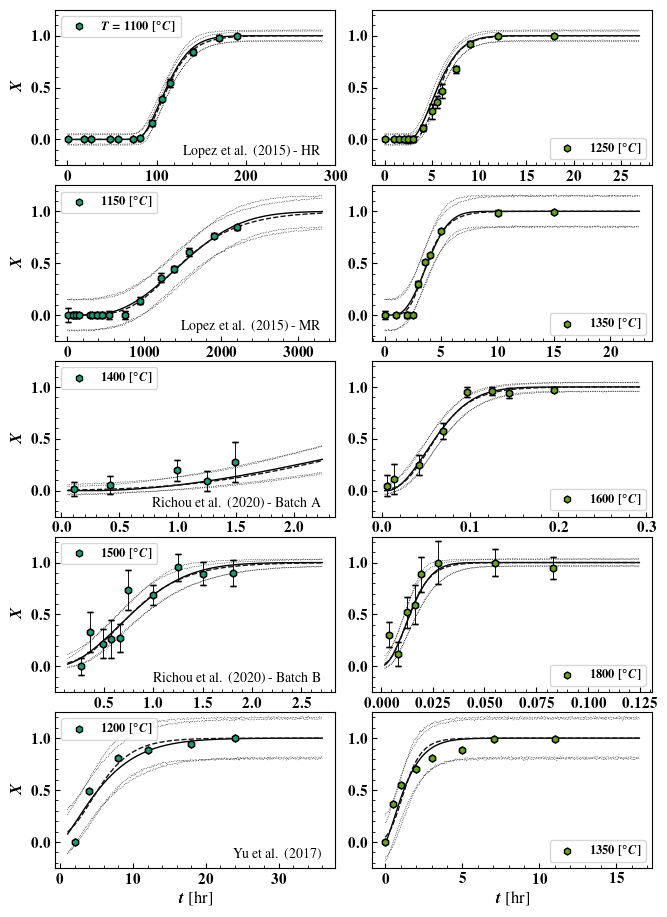

In [104]:
def jmak_model(t: np.ndarray,T:np.ndarray,a1: float,B1: float,a2: float,B2: float,n: float) -> np.ndarray:
    """
    So we can just plug in a point estimate easily
    """
    b = np.exp(a1 + B1/T)
    t_inc = np.exp(a2 + B2/T)
    return 1.0 - np.exp(-b**n*(np.where(t > t_inc, t,t_inc) - t_inc)**n)

def glm_model(t: np.ndarray,T:np.ndarray,a1: float,B1: float,a2: float,B2: float,nu: float) -> np.ndarray:
    B = np.exp(a1 + B1/T)
    M = np.exp(a2 + B2/T)

    #model prediction
    return (1.+ np.exp(-B*(t - M)))**(-1./nu)

def plot_posterior_prediction(ax: plt.Axes,
                              model_func: Callable,
                              ml_est: np.ndarray,
                              posterior_predictive: numpyro.infer.Predictive,
                              temperature: float,
                              exp_data: pd.DataFrame,
                              style: str = '-',
                              pred_color: str = 'k') -> None:
    
    """
    helper function to plot posterior prediction summaries.
    """
    data = exp_data.loc[df['temperature'] == temperature]
    t = np.linspace(data['time'].min()*0.5,data['time'].max()*1.5,300)

    #sample from the posterior predictive
    predictions = posterior_predictive(rng_key_,t = jnp.array(t),
                                                    T = jnp.ones_like(t)*temperature + 273.15,
                                                    X = None,
                                                    std = jnp.zeros_like(t),
                                                    pmean = np.empty_like(ml_est),
                                                    pstd = np.empty_like(ml_est))

    #Estimate using ML parameters
    ml_pred = model_func(t,(temperature + 273.15)*np.ones_like(t),
                        *ml_est)

    #Confidence Intervals using HPDI
    lower,upper = numpyro.diagnostics.hpdi(predictions['obs'],0.95)

    #Visualize the results using ML + HPDI
    ax.plot(t/3600,ml_pred,color = pred_color,lw = 1.0,ls = style)
    ax.plot(t/3600,lower,color = 'k',lw = 0.5,ls = ':')
    ax.plot(t/3600,upper,color = 'k',lw = 0.5,ls = ':')  
    

def plot_experimental_data(ax: plt.Axes,
                           exp_data: pd.DataFrame,
                           temperature: float,
                           color: str,
                           first_label = True,
                           make_label = True) -> None:
    
    """
    helper function to plot data.
    """

    label = r'\textbf{$T = ' + f'{temperature}$' + r' [$^\circ C $]}' if first_label else  r'\textbf{' rf'${temperature}$' + r' [$^\circ C $]}'
    data = exp_data.loc[df['temperature'] == temperature]
    
    #plot the data and error bars
    ax.scatter(data['time']/3600,data['X'],facecolor = color,s = 25,
            edgecolor = 'k',zorder = 100,marker = 'h',
            label = label if make_label else None)
    ax.errorbar(data['time']/3600,data['X'],yerr = data['std'],color = 'k',
                fmt = 'none',capsize = 2,elinewidth = 0.5)

#plot the posterior predictive for the JMAK and GLM models for some sample isothermal temperatures
fig,axes = plt.subplots(nrows = 5,ncols = 2,figsize = (6.5,9))

temperatures  = {'rf_data/alfonso_data/highly_rolled.csv': [1100,1250],
                'rf_data/alfonso_data/moderate_roll.csv': [1150,1350],
                'rf_data/richou_data/batch_a_data.csv': [1400,1600],
                'rf_data/richou_data/batch_b_data.csv': [1500,1800],
                 'rf_data/yu_data/data.csv': [1200,1350]}

for k,model_name,model_func,numpyro_model,model_setup,color,style in zip(range(2),['JMAK_{}','Generalized Logistic_{}'],
                                             [jmak_model,glm_model],
                                             [jmak_numpyro_model,glm_numpyro_model],
                                             [jmak_fit_model_setup,gl_fit_model_setup],
                                             ['k',(20/255,20/255,20/255)],
                                             ['-','--']):
    
    for i,file in enumerate(file_to_label.keys()): #count rows/datasets
        with open(f'.inference/{model_name.format(file_to_label[file])}_samples.pkl','rb') as f:
            posterior_samples = pickle.load(f)

        posterior_predictive = numpyro.infer.Predictive(numpyro_model,
                                                        posterior_samples= posterior_samples)
        inf_summary = pd.read_csv(f'.inference/{model_name.format(file_to_label[file])}_params.csv',index_col = 0)
        model_params = ['a1','B1','a2','B2','n','sigma'] if 'JMAK' in model_name else ['a1','B1','a2','B2','nu','sigma']
        a1,B1,a2,B2,n,_ = inf_summary.loc[model_params,'ml'].to_numpy()
        t,T,X,df,bounds,p0 = model_setup(file, mult = file_to_multiplier[file])

        for j,plot_temperature,exp_color in zip(range(2),temperatures[file],plt.get_cmap('Dark2')([0.1,0.6])): #count columns/temperatures
            plot_posterior_prediction(axes[i,j],model_func,np.array([a1,B1,a2,B2,n]),
                                      posterior_predictive,plot_temperature,df,style = style,pred_color = color)
            plot_experimental_data(axes[i,j],df,plot_temperature,exp_color,first_label = (i == 0 and j == 0),
                                   make_label = k == 0)


for ax,data_label in zip(axes[:,0],file_to_label.values()):
    ax.set_ylabel(r'$X$',fontsize = 12)
    ax.text(0.95, 0.05, data_label , ha='right', va='bottom', transform=ax.transAxes, fontsize=10)

for ax in axes[-1,:]:
    ax.set_xlabel(r'$t$ [hr]',fontsize = 12)

for i in range(5):
    for j in range(2):
        setup_axis_default(axes[i,j])
        axes[i,j].set_ylim([-0.25,1.25])
        #ax.set_xscale('log')   
        #final formatting
        if j == 1:
            axes[i,j].legend(fontsize = 9,ncol = 2,loc = 'lower right')
        else:
            axes[i,j].legend(fontsize = 9,ncol = 2,loc = 'upper left')
        

fig.tight_layout(pad = 0.1) 
fig.savefig('.git_images/posterior_predictive_comparison.svg')


### Parameter Marginal Posterior Visualization

It is useful to examine the marginal posterior distributions of the parameters $a_1,B_1,a_2,B_2,n$ or $a_1,B_1,a_2,B_2,\nu$ as shown below. The samples are plotted as a histogram, shown with the initial parameter guesses obtained using least squares, as well as the mean values. A kde model is fit to the samples, and stored for use in later analysis.

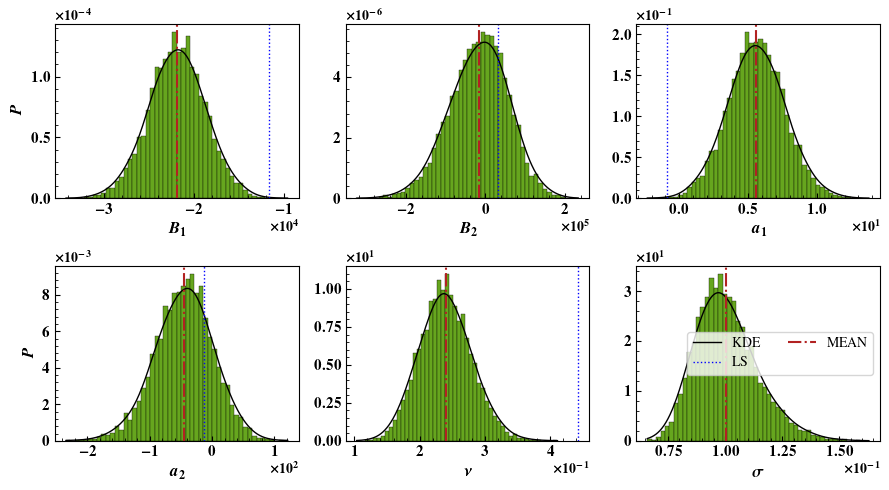

In [100]:
from scipy.stats import gaussian_kde

#setup
file = 'rf_data/yu_data/data.csv'
model_name = 'Generalized Logistic_{}'
with open(f'.inference/{model_name.format(file_to_label[file])}_samples.pkl','rb') as f:
    posterior_samples = pickle.load(f)

#get inference summary from file
inf_summary = pd.read_csv(f'.inference/{model_name.format(file_to_label[file])}_params.csv',index_col = 0)

fig,axes = plt.subplots(figsize = (9,5),nrows = 2,ncols = 3)
xlabels = {'a1': r'$a_1$','a2': r'$a_2$', 'B1': r'$B_1$', 'B2': r'$B_2$', 'n': r'$n$','sigma': r'$\sigma$'} \
if 'JMAK' in model_name else {'a1': r'$a_1$','a2': r'$a_2$', 'B1': r'$B_1$', 'B2': r'$B_2$', 'nu': r'$\nu$','sigma': r'$\sigma$'}

#read in least squares estimates made in initial_least_squares_comparison.ipynb
with open(f'.model/{model_name.format(file_to_model[file])}_weighted.pkl','rb') as f:
    a1,B1,a2,B2,nu = get_model_params(pickle.load(f))

#initialize the model with the least squares estimates
init_values = {'a1': a1,'a2': a2,'B1': B1,'B2': B2,'nu': nu,'sigma': np.nan} if 'Generalized Logistic' in model_name else {'a1': a1,'a2': a2,'B1': B1,'B2': B2,'n': nu,'sigma': np.nan}

#plot the posterior samples and the KDE,initial LS estimates, and ML estimates
kde = {}
for ax,key in zip(np.ravel(axes),posterior_samples.keys()):
    setup_axis_default(ax)
    ax.hist(np.array(posterior_samples[key]),bins = 50,edgecolor = 'k',
            color = plt.get_cmap('Dark2')(0.5),density = True,lw = 0.25)
    
    kde[key] = gaussian_kde(np.array(posterior_samples[key]),bw_method = 0.35)

    x = np.linspace(np.min(posterior_samples[key]),
                    np.max(posterior_samples[key]),1000)
    
    pde_plot = kde[key](x)

    ax.plot(x,pde_plot,color = 'k',lw = 1.0,label = 'KDE')
    ax.axvline(init_values[key],color = 'blue',lw = 1.0,ls = ':',label = 'LS')
    ax.axvline(inf_summary.loc[key,'mean'],color = 'firebrick',lw = 1.5,ls = '-.',label = 'MEAN')
    ax.set_xlabel(xlabels[key],fontsize = 12)
    ax.ticklabel_format(axis = 'both',style = 'sci',scilimits = (0,0))   

#final formatting
axes[-1,-1].legend(fontsize = 10,ncols = 2)
for i in range(2):
    axes[i,0].set_ylabel('$P$',fontsize = 12)

fig.tight_layout()

#store KDES for later visualization and analysis
with open(f'.inference/{model_name.format(file_to_label[file])}_kde.pkl','wb') as f:
    dill.dump(kde,f)



### Paramter Posterior Comparison Visualization 

As some final anaylsis, lets visualize the parameter marginal posteriors and compare for each dataset, shown below. There is clear distinction between $a_1,B_1,n$ in both the JMAK and GL models, and they seem to play the same role as the means follow the same relative ordering between studies. The parameters $a_2$ and $B_2$ are much more varied, though they seem to cluster slightly more for the GL model then the JMAK model. Finally, there is more distinction between probability distributions for $\nu$ in the GL model then there is for $n$.

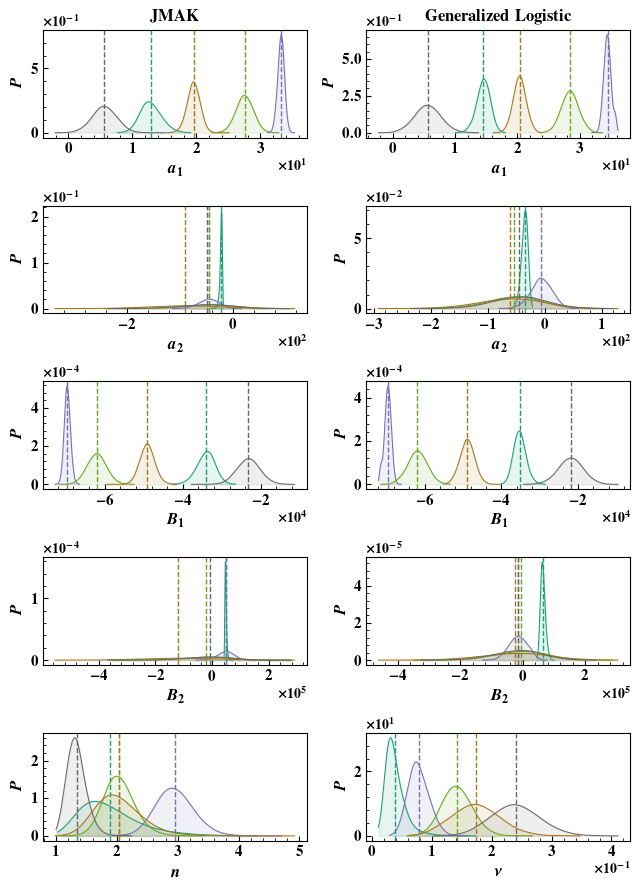

In [103]:
fig,axes = plt.subplots(nrows = 5,ncols = 2,figsize = (6.5,9))

colors = plt.get_cmap('Dark2')(np.linspace(0,1,len(file_to_label)))
for k,model_name in enumerate(['JMAK_{}','Generalized Logistic_{}']):
    parameters = {'a1': r'$a_1$','a2': r'$a_2$', 'B1': r'$B_1$', 'B2': r'$B_2$', 'n': r'$n$'} \
    if 'JMAK' in model_name else {'a1': r'$a_1$','a2': r'$a_2$', 'B1': r'$B_1$', 'B2': r'$B_2$', 'nu': r'$\nu$'}

    for i,file in enumerate(file_to_label.keys()):
        #read stored KDES + summary stats of parameters for later visualization and analysis
        with open(f'.inference/{model_name.format(file_to_label[file])}_kde.pkl','rb') as f:
            model_kde = dill.load(f)
            
        with open(f'.inference/{model_name.format(file_to_label[file])}_samples.pkl','rb') as f:
            posterior_samples = pickle.load(f)
        
        #get inference summary from file
        inf_summary = pd.read_csv(f'.inference/{model_name.format(file_to_label[file])}_params.csv',index_col = 0)
        for ax,param in zip(axes[:,k],parameters):
            
            ax.axvline(inf_summary.loc[param,'mean'],color = colors[i],lw = 1.0,ls = '--')
            x = np.linspace(np.min(posterior_samples[param]),
                        np.max(posterior_samples[param]),1000)
            pde_plot = model_kde[param](x)
            ax.plot(x,pde_plot,color = colors[i],label = file_to_label[file],lw = 0.75)
            ax.fill_between(x,0,pde_plot,color = colors[i],alpha = 0.1)

    for ax,p in zip(axes[:,k],parameters.values()):
        setup_axis_default(ax)
        ax.ticklabel_format(axis = 'both',style = 'sci',scilimits = (0,0))   
        ax.set_xlabel(p,fontsize = 12)
        ax.set_ylabel('$P$',fontsize = 12)

axes[0,0].set_title(r'\textbf{JMAK}',fontsize = 12)
axes[0,1].set_title(r'\textbf{Generalized Logistic}',fontsize = 12)

fig.tight_layout()
fig.savefig('.git_images/posterior_kde_comparison.svg',bbox_inches = 'tight')

### Intra Parameter Correlation 

Visually, it seems like there is a decent amount of correlation between parameters $a_1,B_1,n/\nu$ from the posterior PDF plots between models. This is confirmed by the correlation plots below:

### JMAK Observations:

1. $a_1$ and $B_1$ are nearly perfectly negatively correlated and have very low uncertainty in their values.
2. $a_1$ and $n$ and $B_1$ and $a_1$ are reasonably positively correlated.
3. There is no obvious correlation between $a_2,B_2$ and any of the other variables.

### GLM Observations:

1. $a_1$ and $B_1$ are nearly perfectly negatively correlated and have very low uncertainty in their values.
2. $a_1$ and $n$ and $B_1$ and $a_1$ are reasonably positively correlated, though the data from ALfonso $et al$ HR breaks this trend.
3. There is no obvious correlation between $a_2,B_2$ and any of the other variables, though the values are more tightly clustered than in the JMAK model.

The reasonable conclusion is that subsets of the parameters are linearly related between datasets, which in turn suggests that a linear _latent_ model exists that could allow fitting across all data sets. This idea is developed in [jmak_hierarchical_model.ipynb](jmak_hierarchical_model).

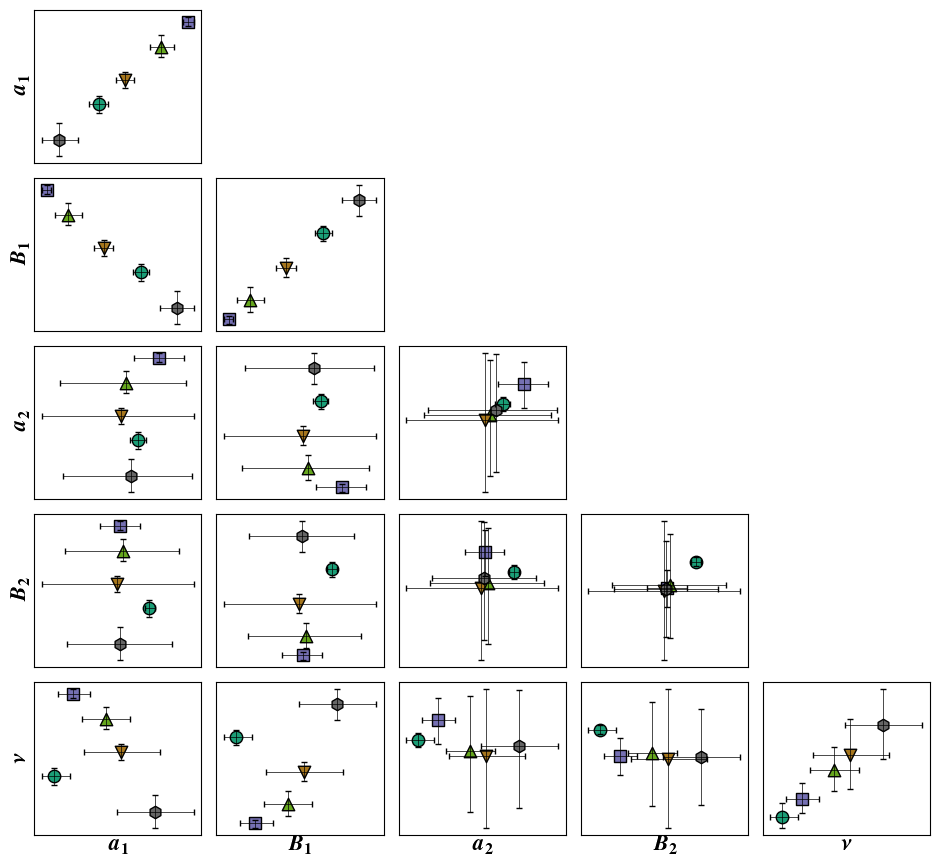

In [107]:
from common_util import hdi
import math 

model_name = 'Generalized Logistic_{}'

#store loaded results
inference_results = {}

for data_name in file_to_label.values():
    inf_params = pd.read_csv(f'.inference/{model_name.format(data_name)}_params.csv',index_col = 0).T
    
    #load the samples from a file
    with open(f'.inference/{model_name.format(data_name)}_samples.pkl','rb') as f:
        samples = pd.DataFrame.from_dict(pickle.load(f))
    
    #compute the HDI
    for j,col in enumerate(list(samples.columns)):
        for label,ci in zip(['lower','upper'],hdi(samples[col].to_numpy(),0.95).squeeze()):
            inf_params.loc[label,col] = ci
    
    inference_results[data_name]  = inf_params.T

#setup plot
model_params = ['a1','B1','a2','B2','n'] if 'JMAK' in model_name else ['a1','B1','a2','B2','nu']
fig,axes = plt.subplots(nrows = len(model_params),
                      ncols = len(model_params),
                      figsize = (9.5,8.75))

#formatting for the plot
symbols = np.array(['o','s','^','v','h'])
colors = plt.get_cmap('Dark2')(np.linspace(0,1,len(file_to_label)))

ylabels = {'a1':r'$a_1$','B1':r'$B_1$','a2': r'$a_2$','B2':r'$B_2$','n':r'$n$'} if 'JMAK' in model_name \
    else {'a1':r'$a_1$','B1':r'$B_1$','a2': r'$a_2$','B2':r'$B_2$','nu':r'$\nu$'}
symbols = np.array(['o','s','^','v','h'])

#plot the intra model correlation results
for i,param1 in enumerate(model_params):
    for j,param2 in enumerate(model_params[:i+1]):
        for k,data_name in enumerate(file_to_label.values()):
            ml_params = inference_results[data_name]
            xerr  = np.abs(ml_params.loc[param1,['mean']].to_numpy() - ml_params.loc[param1,['lower','upper']].to_numpy())
            yerr = np.abs(ml_params.loc[param2,['mean']].to_numpy() - ml_params.loc[param2,['lower','upper']].to_numpy())
            
            axes[i,j].scatter(ml_params.loc[param1,'mean'],ml_params.loc[param2,'mean'],color = colors[k],
                    marker = symbols[k],s = 80,edgecolor = 'k')
            axes[i,j].errorbar(ml_params.loc[param1,'mean'],ml_params.loc[param2,'mean'],
                        yerr= yerr[:,np.newaxis],xerr = xerr[:,np.newaxis],
                        elinewidth = 0.5,capsize = 2,ls = 'none',color = 'k')

        if i == len(model_params) - 1:
            axes[i,j].set_xlabel(ylabels[param2],fontsize = 16,labelpad = 0)

        if j == 0:
            axes[i,j].set_ylabel(ylabels[param1],fontsize = 16,labelpad = 3)
        setup_axis_default(axes[i,j])
        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])

    for j in range(i+1,len(model_params)):
        axes[i,j].axis('off')

fig.tight_layout()
fig.savefig('.temp_images/intra_model_correlation.svg')